In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (
    LinearRegression,
    PoissonRegressor,
    GammaRegressor,
    HuberRegressor,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Import datasets
from doubt.datasets import (
    Airfoil,
    Blog,
    Concrete,
    CPU,
    FacebookComments,
    FishBioconcentration,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
    SpaceShuttle,
    Yacht,
)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt

plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from collections import defaultdict
import seaborn as sns

sns.set_theme(style="whitegrid")
import shap

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [3]:
ls data

LICENSE.md   dev_in.csv   dev_out.csv  train.csv


In [4]:
train = pd.read_csv("data/train.csv", nrows=10_000)
test = pd.read_csv("data/dev_out.csv", nrows=10_000)

In [5]:
cols = [
    "fact_time",
    "fact_latitude",
    "fact_longitude",
    "fact_temperature",
    "fact_cwsm_class",
    "climate",
]

In [6]:
X_tr = train.drop(columns=cols).fillna(-1)
y_tr = train.fact_temperature

X_te = test.drop(columns=cols).fillna(-1)
y_te = test.fact_temperature

In [20]:
X_tr

,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,cmc_0_0_0_2_grad,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,cmc_0_0_0_500,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,127.0,-17.526443,14.613571,754.263405,282.702881,6.684790,276.300439,282.985229,276.300439,262.333789,...,0.0,0.000000,0.0,0.000000,0.0,0.0,-2.600006,-2.750006,0.0,0.0
1,297.0,41.531032,26.992143,733.117168,305.860669,-1.361548,303.629541,302.267993,303.629541,267.178882,...,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.600006,17.950006,-12.0,11.0
2,-1.0,43.916531,18.842143,761.571076,294.469702,0.282837,295.153361,295.341919,295.059082,268.584375,...,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.233978,21.450006,1.0,8.0
3,193.0,40.240955,8.303571,747.524910,295.118774,1.091162,296.376611,297.467773,296.376611,262.566675,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.059448,16.150018,-58.0,41.0
4,90.0,30.394660,6.451429,753.168113,281.233203,-1.461133,282.810181,281.349048,282.810181,242.905981,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.400024,3.150018,18.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,80.0,-53.813531,5.315000,760.867358,278.786377,-0.116919,277.975301,277.936328,278.053247,246.370508,...,0.0,0.001520,0.0,0.002502,0.0,0.0,0.340332,-3.631964,0.0,1.0
9996,-30.0,-62.716203,9.308571,762.043020,282.014185,0.231592,280.577344,280.731738,280.500146,253.155371,...,0.0,0.000040,0.0,0.000000,0.0,0.0,-1.643188,-5.684332,0.0,0.0
9997,268.0,-34.256935,21.209286,739.258300,298.904712,0.325647,297.269678,297.595325,297.269678,268.818506,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.133911,23.383905,-16.0,5.0
9998,20.0,78.041237,22.745714,757.114103,295.474219,0.491724,296.347095,296.838818,296.347095,264.911304,...,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.557434,16.032312,0.0,0.0


In [21]:
standard_scaler = StandardScaler()

# Scale the dataset
# X_tr = standard_scaler.fit_transform(X_tr)
# X_te = standard_scaler.transform(X_te)


# Fit the regressor
regressor = Boot(XGBRegressor(max_depth=5, n_estimators=50))
regressor.fit(X_tr, y_tr, n_boots=20)

Boot(model=XGBRegressor, random_seed=None)

In [8]:
# Train preds
predictions, intervals = regressor.predict(X_tr, uncertainty=0.05)

In [9]:
values = {}
values["uncertainty_train"] = intervals[:, 1] - intervals[:, 0]
values["mse_train"] = (predictions - y_tr) ** 2

In [10]:
# Test preds
predictions, intervals = regressor.predict(X_te, uncertainty=0.05)
values["uncertainty_test"] = intervals[:, 1] - intervals[:, 0]
values["mse_test"] = (predictions - y_te) ** 2


d = pd.DataFrame(values)

In [11]:
sc = StandardScaler()
sc.fit(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_train"] = sc.transform(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_test"] = sc.transform(d["uncertainty_test"].values.reshape(-1, 1))

sc = StandardScaler()
sc.fit(d["mse_train"].values.reshape(-1, 1))
d["mse_train"] = sc.transform(d["mse_train"].values.reshape(-1, 1))
d["mse_test"] = sc.transform(d["mse_test"].values.reshape(-1, 1))

<AxesSubplot:>

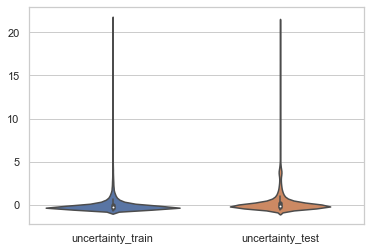

In [12]:
sns.violinplot(data=d.drop(columns=["mse_train", "mse_test"]))

<AxesSubplot:>

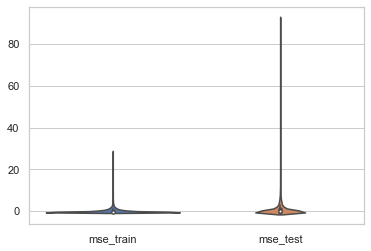

In [13]:
sns.violinplot(data=d.drop(columns=["uncertainty_train", "uncertainty_test"]))

In [14]:
d.describe()

,uncertainty_train,mse_train,uncertainty_test,mse_test
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000
mean,-1.017497e-15,2.113865e-17,0.315342,0.885752
std,1.000050e+00,1.000050e+00,1.503154,3.147273
min,-7.134180e-01,-5.642019e-01,-0.635855,-0.564202
25%,-4.044957e-01,-5.197172e-01,-0.268882,-0.468981
50%,-2.571332e-01,-3.539719e-01,-0.094859,-0.108551
75%,2.430870e-02,1.144703e-01,0.258421,0.907741
max,2.149930e+01,2.854812e+01,21.082673,91.999769


## Detecting the source of uncertainty

In [15]:
reg = XGBRegressor()
reg.fit(X_te, d["uncertainty_test"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
mean_squared_error(reg.predict(X_te), d["uncertainty_test"])

0.012478263416737845

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


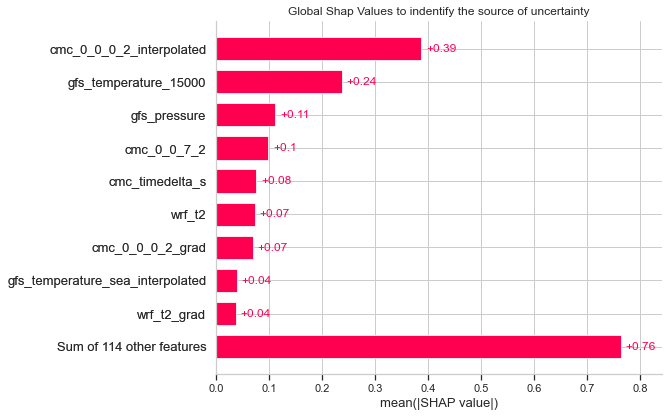

In [17]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_te)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
plt.figure()
plt.title("Global Shap Values to indentify the source of uncertainty")
shap.plots.bar(shap_values, show=False)
plt.savefig("experiments/xai/shap.png")
plt.show()

divide by zero encountered in double_scalars


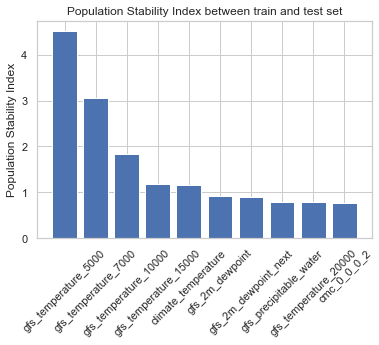

In [19]:
psi_dic = []
for c in X_tr.columns:
    psi_dic.append([c, psi(X_tr[c], X_te[c]),ks_2samp(X_tr[c], X_te[c]).statistic])



psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi",'ks'])


plt.figure()
plt.title('Population Stability Index between train and test set')
plt.ylabel('Population Stability Index')
keys = psi_dic.sort_values("psi", ascending=False).head(10).column.values
values = psi_dic.sort_values("psi", ascending=False).head(10).psi.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.savefig('experiments/xai/psi.png')
plt.show()



In [22]:
psi_dic


,column,psi,ks
0,topography_bathymetry,0.046087,0.2414
1,sun_elevation,0.760932,0.2285
2,climate_temperature,1.165915,0.3352
3,climate_pressure,0.107218,0.2370
4,cmc_0_0_0_1000,0.722932,0.3267
...,...,...,...
118,cmc_0_1_68_0_next,0.010531,0.0201
119,gfs_2m_dewpoint_grad,0.009917,0.0533
120,gfs_2m_dewpoint_next,0.889563,0.3372
121,gfs_total_clouds_cover_low_grad,0.030415,0.0610


In [ ]:
plt.figure()
keys = psi_dic.sort_values("ks", ascending=False).head(10).column.values
values = psi_dic.sort_values("ks", ascending=False).head(10).ks.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.show()